In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, concatenate, Dense, Flatten, Embedding, Bidirectional, Dropout, GlobalMaxPooling1D, BatchNormalization, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [16]:
# Import dataset
import pandas as pd
from IPython.display import display
from sklearn.utils import shuffle

df = pd.read_csv(r"training_data/ACM.csv")
display(df)
df = shuffle(df).reset_index(drop=True)

attack_count = df[df['relationship'] == "a"].count().iloc[0]
support_count = df[df['relationship'] == "s"].count().iloc[0]
neither_count = df[df['relationship'] == "n"].count().iloc[0]

print(attack_count, support_count, neither_count)

# Split features and labels
X = df[["argument1", "argument2"]].T.reset_index(drop=True).T
y = df[["relationship"]].T.reset_index(drop=True).T

display(X)
display(y)

,Unnamed: 0,argument1,argument2,relationship
0,0,"Labour should be running scared of UKIP, now t...",It shows how weak David Cameron has become and...,n
1,1,"If UKIP don't like being smeared, then they ne...",The by-election was called after former Lib De...,n
2,2,I don't believe Farage is a racist and I don't...,No other elections took place in Wales.,n
3,3,"Even a UKIP European candidate, Janice Atkinso...",While Mr Farage did not put a figure on the es...,n
4,4,I think a lot of UKIP supporters would be outr...,"UKIP used to be a protest vote, he explained, ...",a
...,...,...,...,...
4053,4053,the only good thing in this movie was dr schul...,you must have bad taste in movies,a
4054,4054,after all the attention and awards etc and an ...,i loved the film and its your opinion if you d...,a
4055,4055,after all the attention and awards etc and an ...,i agree did not like this either in fact i sto...,s
4056,4056,after all the attention and awards etc and an ...,i too was not too crazy about it there was too...,s


1316 1348 1394


,0,1
0,If there are enough Ukip votes it should frigh...,Voters in Oldham East and Saddleworth go to th...
1,The only reason we are even having a sensible ...,Isolating Britain and damaging Britain's reput...
2,the problem with your argument is that it simp...,for starters httpwww
3,"I think the view of many supporters (not, nece...",The BBC understands that the prime minister's ...
4,i could argue the many reasons i dont believe ...,science involves observations theory design te...
...,...,...
4053,creationist want god to be both all powerful a...,genesis is very clear that the evening and the...
4054,in arguing for the existence of god dr,of course id has to move from its position of ...
4055,"In fact, all UKIP seems to talk about now is w...",Ms Andreasen had been UKIP's sole remaining fe...
4056,UKIP's sole aim at the general election is to ...,"Earlier this year, UKIP leader Nigel Farage sa..."


,0
0,n
1,a
2,a
3,n
4,a
...,...
4053,a
4054,s
4055,n
4056,s


In [17]:
# Split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split pairs of sentences
sentences_train_1 = X_train[0].to_numpy()
sentences_train_2 = X_train[1].to_numpy()

sentences_test_1 = X_test[0].to_numpy()
sentences_test_2 = X_test[1].to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [18]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# prepare target
le = LabelEncoder()
le.fit(np.ravel(y))
y_train_enc = le.transform(np.ravel(y_train))
y_test_enc = le.transform(np.ravel(y_test))
print(y_test_enc)

# one hot encoded
y_train_enc = to_categorical(y_train_enc)
y_test_enc = to_categorical(y_test_enc)

print(y_train_enc, y_test_enc)

[0 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 2 1 2 2 1 1 2 2 2 0 1 2 1 0 0 2 1 0 2 0
 1 1 2 1 1 2 2 1 0 0 2 1 0 0 1 0 0 2 0 2 2 0 0 0 0 0 1 0 1 1 2 2 0 1 2 2 1
 2 0 2 1 1 2 2 1 2 0 1 1 2 1 2 1 0 2 0 1 0 2 2 0 2 2 2 0 2 2 1 1 1 1 2 1 0
 2 1 0 1 0 2 1 0 1 0 2 1 2 1 2 0 0 0 1 1 1 1 0 1 2 2 0 2 0 1 2 1 2 1 0 1 1
 0 2 2 0 1 2 2 0 1 0 2 1 2 0 2 0 2 2 2 1 2 0 1 2 2 2 1 2 0 1 1 2 2 2 2 0 2
 0 1 0 1 2 0 2 1 1 2 1 2 0 0 1 0 2 2 2 2 0 1 1 0 1 2 1 0 1 0 1 1 1 1 0 1 1
 2 1 2 2 2 1 2 0 0 2 0 2 2 1 0 0 0 2 0 1 1 2 0 1 2 1 1 1 0 1 1 0 2 1 2 2 2
 0 2 1 1 0 2 0 0 2 0 1 1 1 0 1 2 0 1 1 0 1 2 1 0 2 0 1 0 1 0 0 1 0 1 2 1 2
 2 1 1 1 0 2 2 0 2 2 2 1 0 1 2 2 1 1 2 1 1 0 0 1 0 1 1 1 0 1 1 1 2 1 2 1 2
 0 0 1 0 1 2 0 2 1 1 1 0 0 2 1 0 2 0 1 2 0 2 0 1 0 2 0 0 1 2 0 1 1 0 1 0 2
 0 0 2 2 2 1 1 0 2 2 0 0 0 2 2 1 0 1 2 0 1 1 0 2 2 2 2 2 1 2 2 0 1 1 0 0 0
 0 2 1 2 2 0 0 2 2 0 1 0 0 1 2 2 0 1 0 1 1 0 0 1 0 1 0 0 1 2 2 0 0 0 1 1 0
 2 0 1 2 0 1 2 0 1 0 0 0 0 0 1 0 0 2 2 0 2 2 0 1 2 2 2 1 0 1 0 1 2 1 0 2 1
 1 0 2 1 2 2 0 1 2 0 2 0 

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Flatten features for Glove fitting
texts = np.concatenate([X[0], X[1]])

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
# Encode training data
sequences_train_1 = tokenizer.texts_to_sequences(sentences_train_1)
sequences_train_2 = tokenizer.texts_to_sequences(sentences_train_2)

# Encode testing data
sequences_test_1 = tokenizer.texts_to_sequences(sentences_test_1)
sequences_test_2 = tokenizer.texts_to_sequences(sentences_test_2)

# Padding sequences to have the same length
max_len = 50
print(max_len)

padded_sequences_train_1 = pad_sequences(sequences_train_1, maxlen=max_len, padding='post')
padded_sequences_train_2 = pad_sequences(sequences_train_2, maxlen=max_len, padding='post')

padded_sequences_test_1 = pad_sequences(sequences_test_1, maxlen=max_len, padding='post')
padded_sequences_test_2 = pad_sequences(sequences_test_2, maxlen=max_len, padding='post')

#print(padded_sequences_test_2)

50


In [20]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
# Create input layers
#input_shape = (50, 100)
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 50, 300)              2520900   ['input_7[0][0]']             
                                                                                                  
 embedding_7 (Embedding)     (None, 50, 300)              2520900   ['input_8[0][0]']             
                                                                                            

In [24]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.0001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - 7s 177ms/step - loss: 0.9228 - accuracy: 0.5159 - val_loss: 0.8756 - val_accuracy: 0.5354
Epoch 2/50
23/23 [==============================] - 3s 151ms/step - loss: 0.7339 - accuracy: 0.6388 - val_loss: 0.8152 - val_accuracy: 0.5600
Epoch 3/50
23/23 [==============================] - 4s 182ms/step - loss: 0.6690 - accuracy: 0.6796 - val_loss: 0.7581 - val_accuracy: 0.6000
Epoch 4/50
23/23 [==============================] - 5s 201ms/step - loss: 0.6230 - accuracy: 0.7083 - val_loss: 0.7607 - val_accuracy: 0.6185
Epoch 5/50
23/23 [==============================] - 4s 170ms/step - loss: 0.5512 - accuracy: 0.7580 - val_loss: 0.7257 - val_accuracy: 0.6092
Epoch 6/50
23/23 [==============================] - 4s 180ms/step - loss: 0.5126 - accuracy: 0.7782 - val_loss: 0.7449 - val_accuracy: 0.6154
Epoch 7/50
23/23 [==============================] - 4s 160ms/step - loss: 0.4673 - accuracy: 0.8014 - val_loss: 0.7040 - val_accuracy: 0.6523
Epoch 

In [25]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

51/51 [==============================] - 1s 12ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.61      0.53      0.57       271
           1       0.82      0.92      0.87       281
           2       0.57      0.57      0.57       260

    accuracy                           0.68       812
   macro avg       0.67      0.67      0.67       812
weighted avg       0.67      0.68      0.67       812



In [26]:
results = model.evaluate([padded_sequences_test_1, padded_sequences_test_2], y_test_enc, batch_size=32)
print("test loss, test acc:", results)

26/26 [==============================] - 1s 23ms/step - loss: 0.7402 - accuracy: 0.6786
test loss, test acc: [0.7402144074440002, 0.6785714030265808]


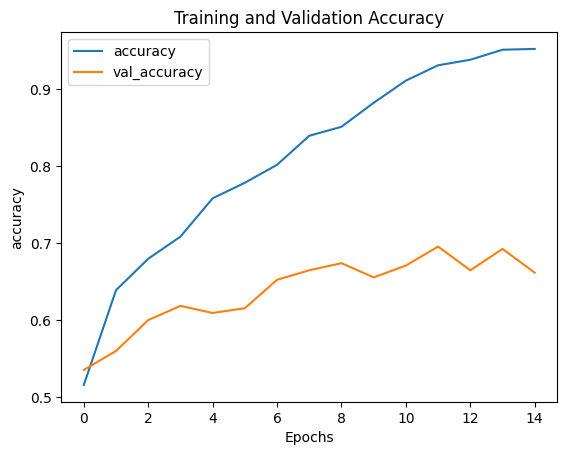

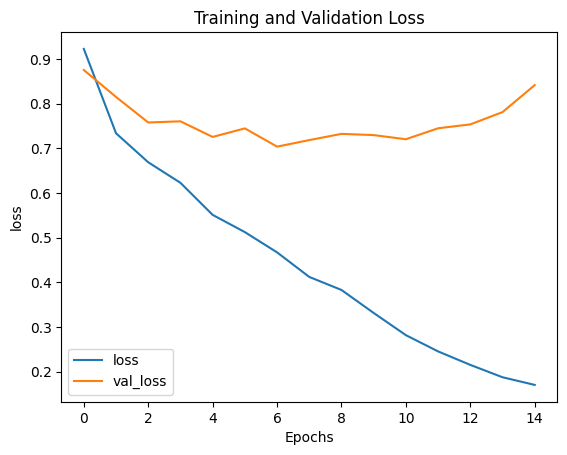

In [27]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title('Training and Validation ' + metric.capitalize())
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [28]:
model.save('../saved_models/ACM_model')

INFO:tensorflow:Assets written to: ../saved_models/ACM_model/assets


INFO:tensorflow:Assets written to: ../saved_models/ACM_model/assets


In [29]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
# BASE MODEL

In [31]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.100d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [32]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=32, return_sequences=True)(emb1)
lstm2 = LSTM(units=32, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
base_model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
base_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 50, 100)              840300    ['input_9[0][0]']             
                                                                                                  
 embedding_9 (Embedding)     (None, 50, 100)              840300    ['input_10[0][0]']            
                                                                                            

In [33]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = base_model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - 4s 68ms/step - loss: 0.9960 - accuracy: 0.4618 - val_loss: 0.9915 - val_accuracy: 0.5231
Epoch 2/50
23/23 [==============================] - 1s 35ms/step - loss: 0.8456 - accuracy: 0.5700 - val_loss: 0.8887 - val_accuracy: 0.5785
Epoch 3/50
23/23 [==============================] - 1s 40ms/step - loss: 0.7499 - accuracy: 0.6210 - val_loss: 0.8468 - val_accuracy: 0.5785
Epoch 4/50
23/23 [==============================] - 1s 37ms/step - loss: 0.6849 - accuracy: 0.6724 - val_loss: 0.8503 - val_accuracy: 0.5846
Epoch 5/50
23/23 [==============================] - 1s 38ms/step - loss: 0.6417 - accuracy: 0.7076 - val_loss: 0.8073 - val_accuracy: 0.6092
Epoch 6/50
23/23 [==============================] - 1s 32ms/step - loss: 0.5951 - accuracy: 0.7182 - val_loss: 0.8340 - val_accuracy: 0.6185
Epoch 7/50
23/23 [==============================] - 1s 33ms/step - loss: 0.5426 - accuracy: 0.7545 - val_loss: 0.9033 - val_accuracy: 0.5877
Epoch 8/50
23

In [34]:
from sklearn.metrics import classification_report
y_pred = base_model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

51/51 [==============================] - 1s 3ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.55      0.48      0.51       271
           1       0.83      0.89      0.86       281
           2       0.52      0.56      0.54       260

    accuracy                           0.64       812
   macro avg       0.63      0.64      0.64       812
weighted avg       0.64      0.64      0.64       812



In [35]:
# BASE MODEL WITH 300D GLOVE

In [36]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [37]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=32, return_sequences=True)(emb1)
lstm2 = LSTM(units=32, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 50, 300)              2520900   ['input_11[0][0]']            
                                                                                                  
 embedding_11 (Embedding)    (None, 50, 300)              2520900   ['input_12[0][0]']            
                                                                                            

In [38]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - 4s 75ms/step - loss: 0.9522 - accuracy: 0.5056 - val_loss: 0.8893 - val_accuracy: 0.5569
Epoch 2/50
23/23 [==============================] - 1s 47ms/step - loss: 0.7510 - accuracy: 0.6323 - val_loss: 0.8384 - val_accuracy: 0.5815
Epoch 3/50
23/23 [==============================] - 1s 48ms/step - loss: 0.6630 - accuracy: 0.6799 - val_loss: 0.7877 - val_accuracy: 0.6338
Epoch 4/50
23/23 [==============================] - 1s 48ms/step - loss: 0.5990 - accuracy: 0.7251 - val_loss: 0.8098 - val_accuracy: 0.6154
Epoch 5/50
23/23 [==============================] - 1s 54ms/step - loss: 0.5333 - accuracy: 0.7634 - val_loss: 0.7807 - val_accuracy: 0.6246
Epoch 6/50
23/23 [==============================] - 1s 60ms/step - loss: 0.4744 - accuracy: 0.7956 - val_loss: 0.8392 - val_accuracy: 0.6462
Epoch 7/50
23/23 [==============================] - 1s 60ms/step - loss: 0.4253 - accuracy: 0.8203 - val_loss: 0.8303 - val_accuracy: 0.6462
Epoch 8/50
23

In [39]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

51/51 [==============================] - 1s 5ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.60      0.47      0.53       271
           1       0.77      0.93      0.84       281
           2       0.54      0.55      0.55       260

    accuracy                           0.65       812
   macro avg       0.64      0.65      0.64       812
weighted avg       0.64      0.65      0.64       812



In [40]:
# BASE MODEL WITH 300D GLOVE + 128D LSTM

In [41]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 50, 300)              2520900   ['input_13[0][0]']            
                                                                                                  
 embedding_13 (Embedding)    (None, 50, 300)              2520900   ['input_14[0][0]']            
                                                                                            

In [42]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - 7s 199ms/step - loss: 0.9275 - accuracy: 0.5228 - val_loss: 0.8534 - val_accuracy: 0.5477
Epoch 2/50
23/23 [==============================] - 4s 186ms/step - loss: 0.6952 - accuracy: 0.6635 - val_loss: 0.7787 - val_accuracy: 0.6215
Epoch 3/50
23/23 [==============================] - 6s 260ms/step - loss: 0.6150 - accuracy: 0.7073 - val_loss: 0.7835 - val_accuracy: 0.6062
Epoch 4/50
23/23 [==============================] - 7s 299ms/step - loss: 0.5168 - accuracy: 0.7706 - val_loss: 0.7508 - val_accuracy: 0.6185
Epoch 5/50
23/23 [==============================] - 7s 288ms/step - loss: 0.4195 - accuracy: 0.8244 - val_loss: 0.8687 - val_accuracy: 0.6523
Epoch 6/50
23/23 [==============================] - 6s 284ms/step - loss: 0.3515 - accuracy: 0.8624 - val_loss: 0.8446 - val_accuracy: 0.6308
Epoch 7/50
23/23 [==============================] - 7s 290ms/step - loss: 0.2635 - accuracy: 0.9062 - val_loss: 0.9867 - val_accuracy: 0.6308
Epoch 

In [43]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

51/51 [==============================] - 2s 19ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.60      0.36      0.45       271
           1       0.80      0.91      0.85       281
           2       0.52      0.66      0.58       260

    accuracy                           0.65       812
   macro avg       0.64      0.64      0.63       812
weighted avg       0.64      0.65      0.63       812



In [44]:
# BASE MODEL + 300D GLOVE + 128D LSTM + 1DPOOLING & l2

In [45]:
# Create input layers
#input_shape = (50, 100)
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 50, 300)              2520900   ['input_15[0][0]']            
                                                                                                  
 embedding_15 (Embedding)    (None, 50, 300)              2520900   ['input_16[0][0]']            
                                                                                            

In [46]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - 15s 349ms/step - loss: 1.4418 - accuracy: 0.5354 - val_loss: 1.3412 - val_accuracy: 0.5077
Epoch 2/50
23/23 [==============================] - 7s 284ms/step - loss: 1.1414 - accuracy: 0.6238 - val_loss: 1.1605 - val_accuracy: 0.5569
Epoch 3/50
23/23 [==============================] - 6s 259ms/step - loss: 0.9880 - accuracy: 0.6758 - val_loss: 1.0897 - val_accuracy: 0.6092
Epoch 4/50
23/23 [==============================] - 6s 281ms/step - loss: 0.8860 - accuracy: 0.7165 - val_loss: 1.0130 - val_accuracy: 0.6000
Epoch 5/50
23/23 [==============================] - 7s 286ms/step - loss: 0.7886 - accuracy: 0.7504 - val_loss: 0.9321 - val_accuracy: 0.6431
Epoch 6/50
23/23 [==============================] - 6s 272ms/step - loss: 0.7194 - accuracy: 0.7535 - val_loss: 0.8952 - val_accuracy: 0.6492
Epoch 7/50
23/23 [==============================] - 6s 281ms/step - loss: 0.6445 - accuracy: 0.8179 - val_loss: 0.9100 - val_accuracy: 0.6400
Epoch

In [47]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

51/51 [==============================] - 3s 26ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.61      0.57      0.59       271
           1       0.86      0.87      0.87       281
           2       0.56      0.58      0.57       260

    accuracy                           0.68       812
   macro avg       0.68      0.68      0.68       812
weighted avg       0.68      0.68      0.68       812



In [48]:
# BASE MODEL + 300D GLOVE + 128D BiLSTM

In [49]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
#lstm1 = LSTM(units=128, return_sequences=True)(emb1)
#lstm2 = LSTM(units=128, return_sequences=True)(emb2)
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 50, 300)              2520900   ['input_17[0][0]']            
                                                                                                  
 embedding_17 (Embedding)    (None, 50, 300)              2520900   ['input_18[0][0]']            
                                                                                            

In [50]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - 28s 768ms/step - loss: 0.8852 - accuracy: 0.5368 - val_loss: 0.8140 - val_accuracy: 0.5846
Epoch 2/50
23/23 [==============================] - 14s 581ms/step - loss: 0.6614 - accuracy: 0.6707 - val_loss: 0.7607 - val_accuracy: 0.5969
Epoch 3/50
23/23 [==============================] - 12s 538ms/step - loss: 0.5416 - accuracy: 0.7473 - val_loss: 0.7664 - val_accuracy: 0.6277
Epoch 4/50
23/23 [==============================] - 13s 574ms/step - loss: 0.4513 - accuracy: 0.8038 - val_loss: 0.8087 - val_accuracy: 0.6277
Epoch 5/50
23/23 [==============================] - 14s 600ms/step - loss: 0.3581 - accuracy: 0.8583 - val_loss: 0.8880 - val_accuracy: 0.6123
Epoch 6/50
23/23 [==============================] - 12s 539ms/step - loss: 0.2634 - accuracy: 0.9021 - val_loss: 0.8893 - val_accuracy: 0.6338
Epoch 7/50
23/23 [==============================] - 13s 578ms/step - loss: 0.2079 - accuracy: 0.9315 - val_loss: 0.9847 - val_accuracy: 0.6338

In [51]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

51/51 [==============================] - 6s 46ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       271
           1       0.80      0.91      0.85       281
           2       0.55      0.53      0.54       260

    accuracy                           0.66       812
   macro avg       0.65      0.66      0.65       812
weighted avg       0.65      0.66      0.65       812



In [52]:
# BASE MODEL + 300D GLOVE + 128D LSTM

In [53]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, 50, 300)              2520900   ['input_19[0][0]']            
                                                                                                  
 embedding_19 (Embedding)    (None, 50, 300)              2520900   ['input_20[0][0]']            
                                                                                            

In [54]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - 17s 365ms/step - loss: 0.8979 - accuracy: 0.5306 - val_loss: 0.8882 - val_accuracy: 0.5508
Epoch 2/50
23/23 [==============================] - 6s 281ms/step - loss: 0.6844 - accuracy: 0.6703 - val_loss: 0.7729 - val_accuracy: 0.6123
Epoch 3/50
23/23 [==============================] - 6s 258ms/step - loss: 0.5686 - accuracy: 0.7504 - val_loss: 0.8546 - val_accuracy: 0.5938
Epoch 4/50
23/23 [==============================] - 7s 287ms/step - loss: 0.4783 - accuracy: 0.7942 - val_loss: 0.7859 - val_accuracy: 0.6369
Epoch 5/50
23/23 [==============================] - 9s 367ms/step - loss: 0.3848 - accuracy: 0.8524 - val_loss: 0.8936 - val_accuracy: 0.6062
Epoch 6/50
23/23 [==============================] - 6s 277ms/step - loss: 0.3159 - accuracy: 0.8723 - val_loss: 0.9229 - val_accuracy: 0.6154
Epoch 7/50
23/23 [==============================] - 6s 278ms/step - loss: 0.2724 - accuracy: 0.8952 - val_loss: 0.9723 - val_accuracy: 0.6277


In [55]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

51/51 [==============================] - 2s 20ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.57      0.39      0.46       271
           1       0.84      0.85      0.85       281
           2       0.52      0.68      0.59       260

    accuracy                           0.64       812
   macro avg       0.64      0.64      0.63       812
weighted avg       0.65      0.64      0.64       812



In [56]:
# Attention upgraded

In [57]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Flatten
from tensorflow.keras.models import Model

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

# Dropouts
dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the attended outputs
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
flat = Flatten()(concatenated)

# Instead of flattening, feed the concatenated attended outputs directly to the dense layer
dense_layer = Dense(32, activation='relu')(flat)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, 50, 300)              2520900   ['input_21[0][0]']            
                                                                                                  
 embedding_21 (Embedding)    (None, 50, 300)              2520900   ['input_22[0][0]']            
                                                                                           

In [58]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - 25s 418ms/step - loss: 0.9093 - accuracy: 0.5214 - val_loss: 0.8960 - val_accuracy: 0.5723
Epoch 2/50
23/23 [==============================] - 6s 254ms/step - loss: 0.7145 - accuracy: 0.6371 - val_loss: 0.8248 - val_accuracy: 0.5815
Epoch 3/50
23/23 [==============================] - 6s 260ms/step - loss: 0.6330 - accuracy: 0.6785 - val_loss: 0.7809 - val_accuracy: 0.6246
Epoch 4/50
23/23 [==============================] - 6s 263ms/step - loss: 0.5446 - accuracy: 0.7402 - val_loss: 0.8026 - val_accuracy: 0.6523
Epoch 5/50
23/23 [==============================] - 6s 263ms/step - loss: 0.4746 - accuracy: 0.7888 - val_loss: 0.8366 - val_accuracy: 0.6492
Epoch 6/50
23/23 [==============================] - 6s 275ms/step - loss: 0.4063 - accuracy: 0.8203 - val_loss: 0.8567 - val_accuracy: 0.6308
Epoch 7/50
23/23 [==============================] - 6s 273ms/step - loss: 0.3120 - accuracy: 0.8785 - val_loss: 0.9182 - val_accuracy: 0.6308


In [59]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

51/51 [==============================] - 5s 19ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.58      0.38      0.46       271
           1       0.86      0.85      0.85       281
           2       0.49      0.68      0.57       260

    accuracy                           0.64       812
   macro avg       0.64      0.63      0.63       812
weighted avg       0.65      0.64      0.63       812



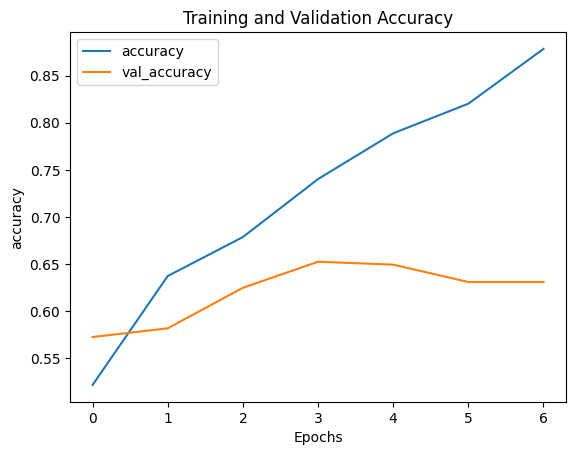

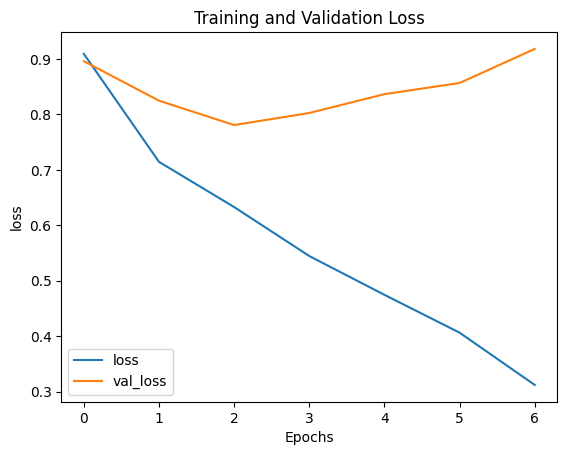

In [60]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title('Training and Validation ' + metric.capitalize())
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [61]:
# Attention + BiLSTM

In [62]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Flatten
from tensorflow.keras.models import Model

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

# Dropouts
dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the attended outputs
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
flat = Flatten()(concatenated)

# Instead of flattening, feed the concatenated attended outputs directly to the dense layer
dense_layer = Dense(32, activation='relu')(flat)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_24 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_22 (Embedding)    (None, 50, 300)              2520900   ['input_23[0][0]']            
                                                                                                  
 embedding_23 (Embedding)    (None, 50, 300)              2520900   ['input_24[0][0]']            
                                                                                           

In [63]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - 40s 805ms/step - loss: 0.9299 - accuracy: 0.5152 - val_loss: 0.8529 - val_accuracy: 0.5538
Epoch 2/50
23/23 [==============================] - 11s 491ms/step - loss: 0.7042 - accuracy: 0.6638 - val_loss: 0.7909 - val_accuracy: 0.6092
Epoch 3/50
23/23 [==============================] - 12s 504ms/step - loss: 0.5894 - accuracy: 0.7285 - val_loss: 0.7994 - val_accuracy: 0.5969
Epoch 4/50
23/23 [==============================] - 12s 515ms/step - loss: 0.4961 - accuracy: 0.7860 - val_loss: 0.7608 - val_accuracy: 0.6308
Epoch 5/50
23/23 [==============================] - 12s 514ms/step - loss: 0.4168 - accuracy: 0.8432 - val_loss: 0.7874 - val_accuracy: 0.6246
Epoch 6/50
23/23 [==============================] - 12s 519ms/step - loss: 0.3079 - accuracy: 0.8850 - val_loss: 0.8777 - val_accuracy: 0.6338
Epoch 7/50
23/23 [==============================] - 12s 510ms/step - loss: 0.2520 - accuracy: 0.9055 - val_loss: 1.0022 - val_accuracy: 0.6338

In [64]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

51/51 [==============================] - 9s 30ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       271
           1       0.89      0.80      0.84       281
           2       0.51      0.57      0.54       260

    accuracy                           0.64       812
   macro avg       0.65      0.64      0.64       812
weighted avg       0.66      0.64      0.65       812



In [65]:
# BASE MODEL + 300D GLOVE + 256D BiLSTM + max1DPooling + attention

In [66]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
#lstm1 = LSTM(units=128, return_sequences=True)(emb1)
#lstm2 = LSTM(units=128, return_sequences=True)(emb2)
lstm1 = Bidirectional(LSTM(units=256, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=256, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_24 (Embedding)    (None, 50, 300)              2520900   ['input_25[0][0]']            
                                                                                                  
 embedding_25 (Embedding)    (None, 50, 300)              2520900   ['input_26[0][0]']            
                                                                                           

In [67]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - 51s 1s/step - loss: 0.9142 - accuracy: 0.5330 - val_loss: 0.8888 - val_accuracy: 0.5323
Epoch 2/50
23/23 [==============================] - 25s 1s/step - loss: 0.7247 - accuracy: 0.6292 - val_loss: 0.7808 - val_accuracy: 0.6092
Epoch 3/50
23/23 [==============================] - 25s 1s/step - loss: 0.6271 - accuracy: 0.7234 - val_loss: 0.7501 - val_accuracy: 0.6523
Epoch 4/50
23/23 [==============================] - 25s 1s/step - loss: 0.5493 - accuracy: 0.7617 - val_loss: 0.7225 - val_accuracy: 0.6431
Epoch 5/50
23/23 [==============================] - 25s 1s/step - loss: 0.4970 - accuracy: 0.8045 - val_loss: 0.7301 - val_accuracy: 0.6769
Epoch 6/50
23/23 [==============================] - 24s 1s/step - loss: 0.4250 - accuracy: 0.8316 - val_loss: 0.7241 - val_accuracy: 0.6431
Epoch 7/50
23/23 [==============================] - 24s 1s/step - loss: 0.3597 - accuracy: 0.8634 - val_loss: 0.6875 - val_accuracy: 0.6646
Epoch 8/50
23/23 [==

In [68]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

51/51 [==============================] - 10s 48ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.54      0.68      0.60       271
           1       0.86      0.85      0.85       281
           2       0.58      0.43      0.49       260

    accuracy                           0.66       812
   macro avg       0.66      0.65      0.65       812
weighted avg       0.66      0.66      0.65       812



In [69]:
# Attention P to C

In [70]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=64, return_sequences=True)(emb1)
lstm2 = LSTM(units=64, return_sequences=True)(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(lstm1, lstm2)
c_to_p_attended = p_to_c_attention(lstm2, lstm1)

# Create LSTM layers
lstm3 = LSTM(units=64, return_sequences=True)(p_to_c_attended)
lstm4 = LSTM(units=64, return_sequences=True)(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_27 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_27 (Embedding)    (None, 50, 300)              2520900   ['input_28[0][0]']            
                                                                                                  
 embedding_26 (Embedding)    (None, 50, 300)              2520900   ['input_27[0][0]']            
                                                                                           

In [71]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 0.9874 - accuracy: 0.4920

W0000 00:00:1712465770.015841       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712465770.017890       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

23/23 [==============================] - 24s 437ms/step - loss: 0.9874 - accuracy: 0.4920 - val_loss: 0.9434 - val_accuracy: 0.5231
Epoch 2/50
23/23 [==============================] - 4s 194ms/step - loss: 0.7871 - accuracy: 0.5909 - val_loss: 0.8679 - val_accuracy: 0.5815
Epoch 3/50
23/23 [==============================] - 5s 199ms/step - loss: 0.7202 - accuracy: 0.6371 - val_loss: 0.8229 - val_accuracy: 0.5815
Epoch 4/50
23/23 [==============================] - 5s 199ms/step - loss: 0.6573 - accuracy: 0.6713 - val_loss: 0.7935 - val_accuracy: 0.5938
Epoch 5/50
23/23 [==============================] - 5s 200ms/step - loss: 0.5996 - accuracy: 0.7104 - val_loss: 0.7903 - val_accuracy: 0.6123
Epoch 6/50
23/23 [==============================] - 5s 208ms/step - loss: 0.5477 - accuracy: 0.7422 - val_loss: 0.8070 - val_accuracy: 0.6708
Epoch 7/50
23/23 [==============================] - 5s 202ms/step - loss: 0.4781 - accuracy: 0.7812 - val_loss: 0.8170 - val_accuracy: 0.6431
Epoch 8/50
23/23

In [72]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1712465825.562572       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712465825.565286       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

51/51 [==============================] - 5s 17ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.52      0.47      0.50       271
           1       0.85      0.88      0.86       281
           2       0.50      0.53      0.51       260

    accuracy                           0.63       812
   macro avg       0.62      0.63      0.62       812
weighted avg       0.63      0.63      0.63       812



In [73]:
# Attention P to C with 2 LSTM 128

In [74]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(lstm1, lstm2)
c_to_p_attended = p_to_c_attention(lstm2, lstm1)

# Create LSTM layers
lstm3 = LSTM(units=128, return_sequences=True)(p_to_c_attended)
lstm4 = LSTM(units=128, return_sequences=True)(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_29 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_29 (Embedding)    (None, 50, 300)              2520900   ['input_30[0][0]']            
                                                                                                  
 embedding_28 (Embedding)    (None, 50, 300)              2520900   ['input_29[0][0]']            
                                                                                           

In [75]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 0.9465 - accuracy: 0.5050

W0000 00:00:1712465858.121995       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712465858.122054       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

23/23 [==============================] - 29s 649ms/step - loss: 0.9465 - accuracy: 0.5050 - val_loss: 0.9081 - val_accuracy: 0.5508
Epoch 2/50
23/23 [==============================] - 10s 449ms/step - loss: 0.7704 - accuracy: 0.5779 - val_loss: 0.8156 - val_accuracy: 0.5354
Epoch 3/50
23/23 [==============================] - 11s 470ms/step - loss: 0.7137 - accuracy: 0.6241 - val_loss: 0.8246 - val_accuracy: 0.5631
Epoch 4/50
23/23 [==============================] - 11s 475ms/step - loss: 0.6443 - accuracy: 0.6717 - val_loss: 0.8271 - val_accuracy: 0.5785
Epoch 5/50
23/23 [==============================] - 11s 467ms/step - loss: 0.5827 - accuracy: 0.6960 - val_loss: 0.7934 - val_accuracy: 0.6062
Epoch 6/50
23/23 [==============================] - 11s 475ms/step - loss: 0.5424 - accuracy: 0.7367 - val_loss: 0.8555 - val_accuracy: 0.5846
Epoch 7/50
23/23 [==============================] - 11s 465ms/step - loss: 0.4810 - accuracy: 0.7693 - val_loss: 0.8026 - val_accuracy: 0.6062
Epoch 8/50

In [76]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1712466025.298338       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712466025.298928       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

51/51 [==============================] - 6s 31ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       271
           1       0.81      0.90      0.85       281
           2       0.55      0.55      0.55       260

    accuracy                           0.66       812
   macro avg       0.65      0.66      0.65       812
weighted avg       0.65      0.66      0.66       812



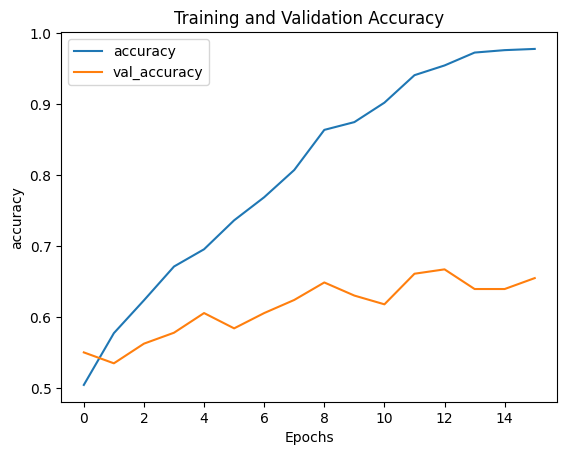

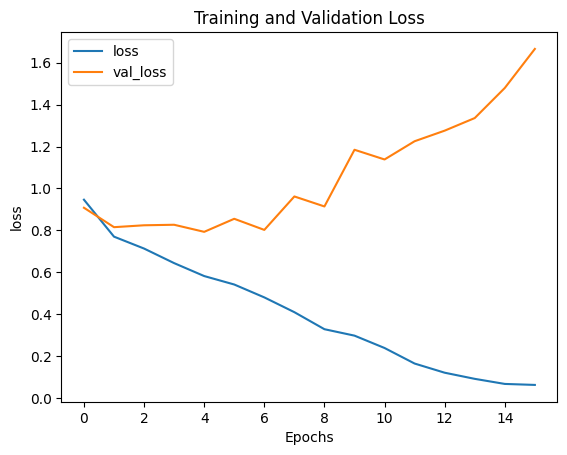

In [77]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title('Training and Validation ' + metric.capitalize())
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [78]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(dropout1, dropout2)
c_to_p_attended = p_to_c_attention(dropout2, dropout1)

# Create LSTM layers
lstm3 = Bidirectional(LSTM(units=128, return_sequences=True))(p_to_c_attended)
lstm4 = Bidirectional(LSTM(units=128, return_sequences=True))(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_31 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_31 (Embedding)    (None, 50, 300)              2520900   ['input_32[0][0]']            
                                                                                                  
 embedding_30 (Embedding)    (None, 50, 300)              2520900   ['input_31[0][0]']            
                                                                                           

In [79]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=16,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
183/183 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.5389

W0000 00:00:1712466111.031616       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712466111.032715       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

183/183 [==============================] - 78s 276ms/step - loss: 0.8605 - accuracy: 0.5389 - val_loss: 0.8328 - val_accuracy: 0.5354
Epoch 2/50
183/183 [==============================] - 41s 224ms/step - loss: 0.7341 - accuracy: 0.5929 - val_loss: 0.8031 - val_accuracy: 0.5200
Epoch 3/50
183/183 [==============================] - 42s 229ms/step - loss: 0.6888 - accuracy: 0.6347 - val_loss: 0.8046 - val_accuracy: 0.5754
Epoch 4/50
183/183 [==============================] - 42s 228ms/step - loss: 0.6631 - accuracy: 0.6375 - val_loss: 0.8133 - val_accuracy: 0.5846
Epoch 5/50
183/183 [==============================] - 42s 229ms/step - loss: 0.6140 - accuracy: 0.6816 - val_loss: 0.8112 - val_accuracy: 0.5754
Epoch 6/50
183/183 [==============================] - 41s 226ms/step - loss: 0.5628 - accuracy: 0.7145 - val_loss: 0.7404 - val_accuracy: 0.6308
Epoch 7/50
183/183 [==============================] - 41s 227ms/step - loss: 0.5070 - accuracy: 0.7504 - val_loss: 0.7394 - val_accuracy: 0.6

In [80]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1712466494.954848       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712466494.955091       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

51/51 [==============================] - 11s 50ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.62      0.52      0.57       271
           1       0.88      0.85      0.86       281
           2       0.52      0.62      0.57       260

    accuracy                           0.67       812
   macro avg       0.67      0.66      0.67       812
weighted avg       0.68      0.67      0.67       812



Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_31 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_31 (Embedding)    (None, 50, 300)              2520900   ['input_32[0][0]']            
                                                                                                  
 embedding_30 (Embedding)    (None, 50, 300)              2520900   ['input_31[0][0]']            
                                                                                           

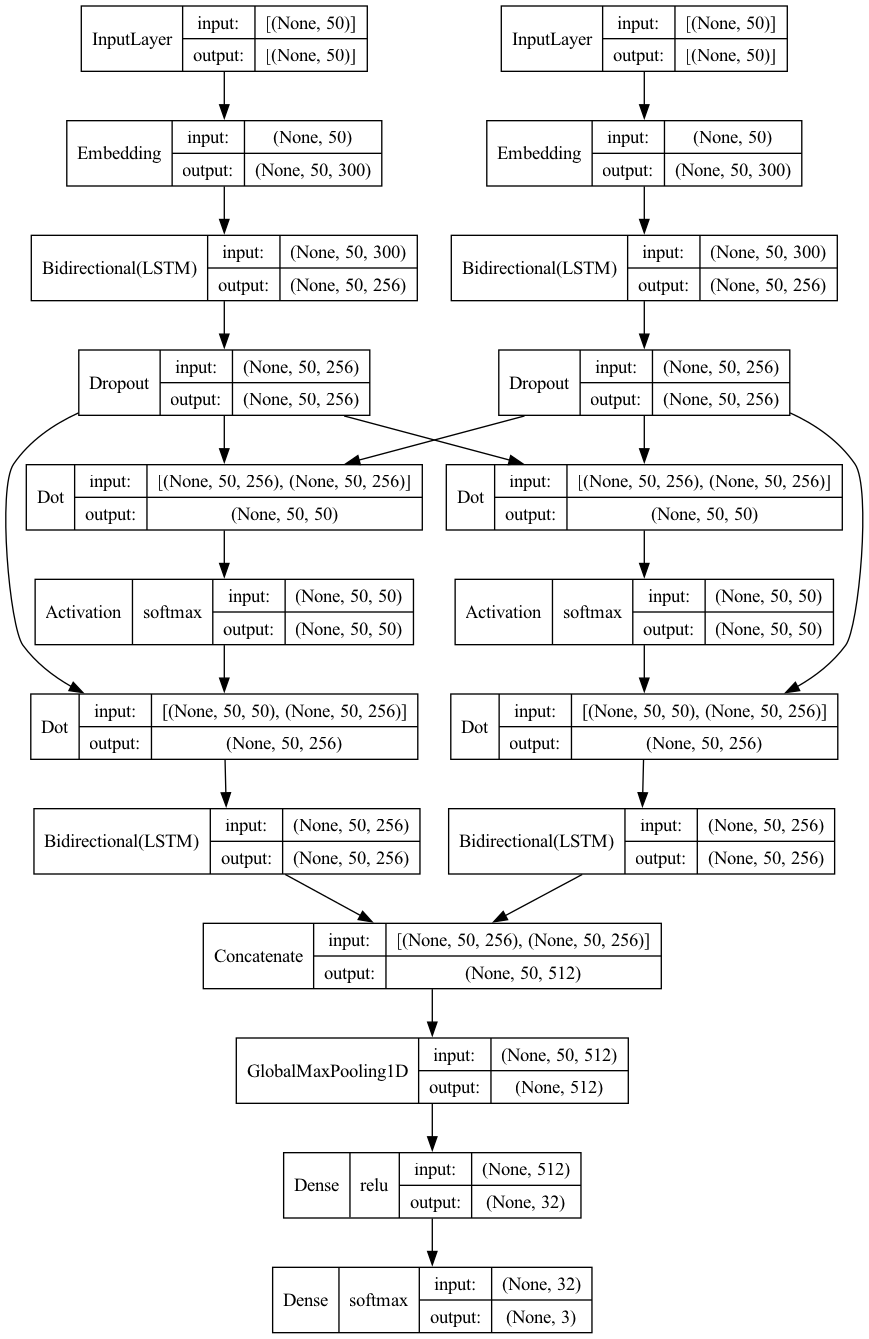

In [81]:
# Show the model architecture
model.summary()
tf.keras.utils.plot_model(model, show_layer_activations=True, show_layer_names=False, show_shapes=True, expand_nested=False)

In [82]:
model.save('../saved_models/ACM_model_final')

INFO:tensorflow:Assets written to: ../saved_models/ACM_model_final/assets


INFO:tensorflow:Assets written to: ../saved_models/ACM_model_final/assets


In [83]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

dropout1 = Dropout(0.5)(lstm1)
dropout2 = Dropout(0.5)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(dropout1, dropout2)
c_to_p_attended = p_to_c_attention(dropout2, dropout1)

# Create LSTM layers
lstm3 = LSTM(units=128, return_sequences=True)(p_to_c_attended)
lstm4 = LSTM(units=128, return_sequences=True)(c_to_p_attended)

dropout3 = Dropout(0.5)(lstm3)
dropout4 = Dropout(0.5)(lstm4)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([dropout3, dropout4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_33 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_33 (Embedding)    (None, 50, 300)              2520900   ['input_34[0][0]']            
                                                                                                  
 embedding_32 (Embedding)    (None, 50, 300)              2520900   ['input_33[0][0]']            
                                                                                           

In [84]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.01,
    patience=1,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=10,
    verbose=1,
    callbacks=[es]
)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.4386 - accuracy: 0.5128

W0000 00:00:1712466606.201338       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712466606.201402       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

23/23 [==============================] - 29s 662ms/step - loss: 1.4386 - accuracy: 0.5128 - val_loss: 1.3318 - val_accuracy: 0.5138
Epoch 2/10
23/23 [==============================] - 11s 482ms/step - loss: 1.1129 - accuracy: 0.5817 - val_loss: 1.1192 - val_accuracy: 0.5477
Epoch 3/10
23/23 [==============================] - 11s 487ms/step - loss: 0.9369 - accuracy: 0.6467 - val_loss: 1.0235 - val_accuracy: 0.6185
Epoch 4/10
23/23 [==============================] - 11s 479ms/step - loss: 0.8121 - accuracy: 0.6960 - val_loss: 0.9315 - val_accuracy: 0.6000


In [85]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1712466644.224658       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712466644.224786       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

51/51 [==============================] - 6s 30ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       271
           1       0.79      0.90      0.84       281
           2       0.53      0.34      0.42       260

    accuracy                           0.65       812
   macro avg       0.63      0.64      0.63       812
weighted avg       0.63      0.65      0.63       812



In [86]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(dropout1, dropout2)
c_to_p_attended = p_to_c_attention(dropout2, dropout1)

# Create LSTM layers
lstm3 = Bidirectional(LSTM(units=128, return_sequences=True))(p_to_c_attended)
lstm4 = Bidirectional(LSTM(units=128, return_sequences=True))(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_35 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_35 (Embedding)    (None, 50, 300)              2520900   ['input_36[0][0]']            
                                                                                                  
 embedding_34 (Embedding)    (None, 50, 300)              2520900   ['input_35[0][0]']            
                                                                                           

In [87]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.01,
    patience=1,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=10,
    verbose=1,
    callbacks=[es]
)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 0.9299 - accuracy: 0.5310

W0000 00:00:1712466710.448345       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712466710.448501       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

23/23 [==============================] - 62s 2s/step - loss: 0.9299 - accuracy: 0.5310 - val_loss: 0.8729 - val_accuracy: 0.5323
Epoch 2/10
23/23 [==============================] - 26s 1s/step - loss: 0.7470 - accuracy: 0.5926 - val_loss: 0.8471 - val_accuracy: 0.5538
Epoch 3/10
23/23 [==============================] - 24s 1s/step - loss: 0.7133 - accuracy: 0.6220 - val_loss: 0.8060 - val_accuracy: 0.5754
Epoch 4/10
23/23 [==============================] - 25s 1s/step - loss: 0.6497 - accuracy: 0.6652 - val_loss: 0.7703 - val_accuracy: 0.6154
Epoch 5/10
23/23 [==============================] - 19s 831ms/step - loss: 0.6055 - accuracy: 0.6936 - val_loss: 0.7303 - val_accuracy: 0.6431
Epoch 6/10
23/23 [==============================] - 18s 792ms/step - loss: 0.5622 - accuracy: 0.7326 - val_loss: 0.7629 - val_accuracy: 0.6215


In [88]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1712466839.728634       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712466839.728758       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

51/51 [==============================] - 15s 48ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.56      0.48      0.52       271
           1       0.84      0.86      0.85       281
           2       0.49      0.54      0.51       260

    accuracy                           0.63       812
   macro avg       0.63      0.63      0.63       812
weighted avg       0.63      0.63      0.63       812

